<a href="https://colab.research.google.com/github/Amanda9805/Detecting-Machine-Generated-Texts/blob/train-model/Afriberta_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade datasets fsspec
!pip install shap lime textstat

In [ ]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize

def clean_and_reformat_data(df, text_column='text', language='zul', clean_text_flag=True, label=None):
    """
    Returns a cleaned DataFrame with:
    - Original text ('text')
    - Cleaned text ('cleaned_text')
    - Word tokens ('tokens')
    - Language label ('language')
    - Optional class label ('label')
    """

    def clean_text(text):
        """Cleans text while preserving original"""
        if not isinstance(text, str):
            return ""

        cleaned = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        cleaned = re.sub(r'[^a-zA-Z\s]', '', cleaned)
        cleaned = cleaned.lower()
        cleaned = ' '.join(cleaned.split())
        return cleaned

    result = {
        'text': [],
        'cleaned_text': [],
        'tokens': [],
        'language': [],
        'label': []
    }

    for index, row in df.iterrows():
        # Get raw text
        raw_text = row.get(text_column, '') or row.get('answers', '')

        # Skip empty entries
        if pd.isna(raw_text) or raw_text == '' or (isinstance(raw_text, (list, tuple)) and len(raw_text) == 0):
            continue

        # Handle list-type text
        if isinstance(raw_text, (list, tuple)):
            raw_text = ' '.join([str(t).strip() for t in raw_text if str(t).strip()])
            if not raw_text:
                continue

        # Clean text
        cleaned = clean_text(raw_text) if clean_text_flag else raw_text
        if not cleaned.strip():
            continue

        # Tokenize
        tokens = word_tokenize(cleaned)

        # Store results
        result['text'].append(raw_text)
        result['cleaned_text'].append(cleaned)
        result['tokens'].append(tokens)
        result['language'].append(language)
        result['label'].append(label if label is not None else row.get('label', None))

    return pd.DataFrame(result)

In [21]:
import pandas as pd
import re
import nltk
from huggingface_hub import login
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from datasets import load_dataset
import numpy as np
import torch


#shona_data = load_dataset("DigitalUmuganda/AfriVoice", "sn", streaming=True, split="train[:10%]")

eng_data = load_dataset("dsfsi/vukuzenzele-monolingual", "eng")
zulu_data = load_dataset("dsfsi/vukuzenzele-monolingual", "zul")
zulu_data2 = load_dataset("masakhane/afriqa", "zul")

combined_eng = pd.concat([
    eng_data['train'].to_pandas(),
    eng_data['test'].to_pandas()
])

combined_data = pd.concat([
    zulu_data['train'].to_pandas(),
    zulu_data['test'].to_pandas()
])

combined_data2 = pd.concat([
    zulu_data2['train'].to_pandas(),
    zulu_data2['validation'].to_pandas(),
    zulu_data2['test'].to_pandas()
])

eng_df = clean_and_reformat_data(combined_eng, text_column='text', language='eng', clean_text_flag=True, label=0)
zul_df1 = clean_and_reformat_data(combined_data, text_column='text', language='zul', clean_text_flag=True, label=0)
zul_df2 = clean_and_reformat_data(combined_data2, text_column='answer', language='zul', clean_text_flag=True, label=0)

zul_df = pd.concat([zul_df1, zul_df2], ignore_index=True)
zul_df.head()
eng_df.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,text,cleaned_text,tokens,language,label
0,The Special Investigation Unit’s (SIU) final r...,the special investigation units siu final repo...,"[the, special, investigation, units, siu, fina...",eng,0
1,"Sumitomo manufactures the popular Dunlop, Sumi...",sumitomo manufactures the popular dunlop sumit...,"[sumitomo, manufactures, the, popular, dunlop,...",eng,0
2,According to the Road Traffic Management Corpo...,according to the road traffic management corpo...,"[according, to, the, road, traffic, management...",eng,0
3,The escalating situation in Israel and Palest...,the escalating situation in israel and palesti...,"[the, escalating, situation, in, israel, and, ...",eng,0
4,"At the time, the nation was reeling from the m...",at the time the nation was reeling from the mu...,"[at, the, time, the, nation, was, reeling, fro...",eng,0


In [22]:
from transformers import pipeline
import json

# en_generator = pipeline('text-generation', model='gpt2')


# english_prompts = [
#     "Explain the significance of lobola in Southern Africa",
#     "Write a short dialogue between two friends in Johannesburg",
#     "Describe linguistic features that make isiZulu agglutinative",
#     "Generate a  news article about corruption in the style of South African government communications.",
#     "Write a news report about economic development in rural communities.",
#     "Write a  discussion about community development challenges and solutions.",
#     "Create a  text about youth employment opportunities and skills development.",
#     "Generate a  article about women's empowerment in rural communities.",
#     "Write about community health and wellness practices in  communities.",
#     "Compose a  text discussing the importance of preserving local languages.",
#     "Create a formal  announcement about a community meeting.",
#     "Write a formal  notice about public services or facilities.",
#     "Write an informal  text message exchange about planning an event.",
#     "Create a  social media post about local community events.",
#     "Create a  troubleshooting guide for common problems.",
#     "Create a  article discussing healthcare initiatives, written as if for a government publication.",
#     "Compose a  news piece about education policy changes, using official government communication style.",
#     "Generate a  article about infrastructure development projects in KwaZulu-Natal.",
#     "Describe a traditional Zulu ceremony in detail, including customs, rituals, and their significance.",
#     "Create a  text explaining traditional farming methods and seasonal practices.",
#     "Generate a  story about ubuntu philosophy and community values.",
#     "Write about traditional  crafts and their cultural importance.",
#     "Compose a  text describing traditional music and dance forms.",
#     "Write a  text teaching basic mathematics concepts to young learners.",
#     "Create a  guide explaining digital literacy for adult learners."
# ]


# def generate_with_prompts(prompts, generator, language, samples_per_prompt=3):
#     data = []
#     for prompt in prompts:
#         for _ in range(samples_per_prompt):
#             output = generator(prompt, max_length=100, do_sample=True, temperature=0.7)
#             data.append({
#                 'text': output
#             })
#     return pd.DataFrame(data)

# eng_mg_df = generate_with_prompts(english_prompts, en_generator, 'English')
# eng_mg_df = clean_and_reformat_data(eng_mg_df, text_column='text', language='eng', clean_text_flag=True, label=1)

def load_jsonl_data(file_path):
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                line = line.strip()
                if line:  # Skip empty lines
                    try:
                        data.append(json.loads(line))
                    except json.JSONDecodeError as e:
                        print(f"Error parsing JSON line: {e}")
                        continue
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return []

    return data

zul_mg_df = pd.DataFrame(load_jsonl_data('zulu_mg_text.jsonl'))
zul_mg_df2 = pd.DataFrame(load_jsonl_data('mg_text.jsonl'))

zul_mg_df1 = clean_and_reformat_data(zul_mg_df, text_column='text', language='zul', clean_text_flag=True, label=1)
zul_mg_df2 = clean_and_reformat_data(zul_mg_df2, text_column='text', language='zul', clean_text_flag=True, label=1)

zul_mg_df = pd.concat([zul_mg_df1, zul_mg_df2], ignore_index=True)


Error parsing JSON line: Invalid \escape: line 1 column 331 (char 330)


COMBINE THE DATASETS
-------------------------

In [23]:
# Combine both datasets, this will be bad for us if we have more than 70% differnce in data length
# Combine both datasets
all_texts = pd.concat([zul_df, zul_mg_df], ignore_index=True)
all_texts_clean = all_texts[
    (all_texts['text'].notna()) &  # Remove NaN/None
    (all_texts['text'].astype(str).str.strip() != '[]') &  # Remove empty lists
    (all_texts['text'].astype(str).str.strip() != "['']") &  # Remove lists with empty strings
    (all_texts['text'].astype(str).str.strip() != '') &  # Remove empty strings
    (all_texts['text'].str.len() > 0)  # Remove zero-length strings
].copy()

all_texts_shuffled = all_texts_clean.sample(frac=1).reset_index(drop=True)
print(f"Total texts after combining: {len(all_texts)}")
print(f"Human-written texts: {len(zul_df)}")
print(f"Machine-generated texts: {len(zul_mg_df)}")

# Create a DataFrame for easier analysis
combined_df = pd.DataFrame(all_texts_shuffled)
combined_df.head()

# Create a balanced dataset with equal samples from each class
# we can choose to use this of the combined one
def create_balanced_dataset(df, target_size_per_class=None):
    class_counts = df['label'].value_counts()
    min_class_size = class_counts.min()
    if target_size_per_class:
        sample_size = min(target_size_per_class, min_class_size)
    else:
        sample_size = min_class_size
    balanced_df = df.groupby('label').sample(n=sample_size, random_state=42)
    return balanced_df.reset_index(drop=True)

# Create balanced dataset, because we need the same number of samples for each class
balanced_df = create_balanced_dataset(combined_df)
print(f"\nBalanced dataset created with {len(balanced_df)} samples")
print(f"Label distribution in balanced dataset: \n{balanced_df['label'].value_counts()}")

# Save balanced dataset
balanced_output_path = 'balanced_zulu_texts.csv'
balanced_df.to_csv(balanced_output_path, index=False, encoding='utf-8')
print(f"Balanced dataset saved to: {balanced_output_path}")
balanced_df.head()

Total texts after combining: 1161
Human-written texts: 852
Machine-generated texts: 309

Balanced dataset created with 618 samples
Label distribution in balanced dataset: 
label
0    309
1    309
Name: count, dtype: int64
Balanced dataset saved to: balanced_zulu_texts.csv


,text,cleaned_text,tokens,language,label
0,Lokhu kugcizelelwe nguMongameli u-Cyril Ramaph...,lokhu kugcizelelwe ngumongameli ucyril ramapho...,"[lokhu, kugcizelelwe, ngumongameli, ucyril, ra...",zul,0
1,['cha'],cha,[cha],zul,0
2,['izigidi ezingama-246 zamarandi'],izigidi ezingama zamarandi,"[izigidi, ezingama, zamarandi]",zul,0
3,['onegunya'],onegunya,[onegunya],zul,0
4,['cha'],cha,[cha],zul,0


Loading AfriBERTa model: castorini/afriberta_base


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Model initialized on cuda
Model parameters: 111,456,770
Filtered 618 Zulu samples from 618 total samples
Training samples: 494
Test samples: 124
Label distribution in training: [247 247]
Label distribution in test: [62 62]
Setting up LoRA configuration...
LoRA enabled. Trainable parameters: 112638724
Starting training with AfriBERTa...


Step,Training Loss,Validation Loss
50,0.474600,0.400817
100,0.280900,0.287466
150,0.340200,0.282339
200,0.396700,0.276188
250,0.158200,0.293520
300,0.229700,0.283705



AFRIBERTA ZULU CLASSIFIER - EVALUATION RESULTS
Overall Accuracy: 0.9032
Weighted Precision: 0.9140
Weighted Recall: 0.9032
Weighted F1-Score: 0.9026

Per-Class Results:
Human:
  Precision: 0.9808
  Recall: 0.8226
  F1-Score: 0.8947
  Support: 62
Machine:
  Precision: 0.8472
  Recall: 0.9839
  F1-Score: 0.9104
  Support: 62

Classification Report:
              precision    recall  f1-score   support

       Human       0.98      0.82      0.89        62
     Machine       0.85      0.98      0.91        62

    accuracy                           0.90       124
   macro avg       0.91      0.90      0.90       124
weighted avg       0.91      0.90      0.90       124

MODEL EXPLAINABILITY ANALYSIS REPORT
Analyzing 30% of data for efficiency

1. FEATURE IMPORTANCE ANALYSIS
----------------------------------------
Analyzing 37 samples (30%) out of 124 total samples
Selected 37 samples for analysis


Generating LIME explanations: 100%|██████████| 37/37 [04:47<00:00,  7.78s/it]


Top features indicating HUMAN text:
  - 'wokukhishwa': 1 occurrences
  - 'ukusebenzisana': 1 occurrences
  - 'zokulwisana': 1 occurrences
  - 'ngezinhlelo': 1 occurrences
  - 'abakuleliukwengeza': 1 occurrences
  - 'africa': 1 occurrences
  - 'yale': 1 occurrences
  - 'umntwana': 1 occurrences
  - 'bengasanakekelwa': 1 occurrences
  - 'isibonelelo': 1 occurrences

Top features indicating MACHINE text:
  - 'kuqinisekiswe': 2 occurrences
  - 'ukuthi': 2 occurrences
  - 'ukudla': 2 occurrences
  - 'umsebenzi': 2 occurrences
  - 'labahleli': 1 occurrences
  - 'ngicabanga': 1 occurrences
  - 'umqondo': 1 occurrences
  - 'ngiyavumelana': 1 occurrences
  - 'ngingcono': 1 occurrences
  - 'abantu': 1 occurrences

2. LINGUISTIC FEATURE ANALYSIS
----------------------------------------
Running linguistic analysis on 37 samples (30%)


Computing linguistic features: 100%|██████████| 37/37 [00:00<00:00, 4251.99it/s]


Avg Sentence Length:
  Human avg: 130.167, Machine avg: 219.632
Lexical Diversity:
  Human avg: 0.936, Machine avg: 0.868
Repetition Score:
  Human avg: 0.064, Machine avg: 0.132

3. ERROR ANALYSIS
----------------------------------------
Found 12 total errors, analyzing 3 in detail


Generating error explanations: 100%|██████████| 3/3 [00:24<00:00,  8.07s/it]


Total classification errors: 12
False positives (Human → Machine): 11
False negatives (Machine → Human): 1

Example misclassifications:
  1. True: Human, Predicted: Machine
     Text: isikhwama esibhekele udlame olubhekiswe kwabo bulili obuthile nokubulawa kwabesifazane igbvf sihlose...
  2. True: Human, Predicted: Machine
     Text: lolu hlelo luhlose ukuthuthukisa ikhono labantwana lokufunda ngokunciphisa ukungondleki kahle nendla...
  3. True: Human, Predicted: Machine
     Text: umphakathi wasedouble drift ngasegrahamstown uhlangani sa abantu abayi abaqha muka emindenini engama...


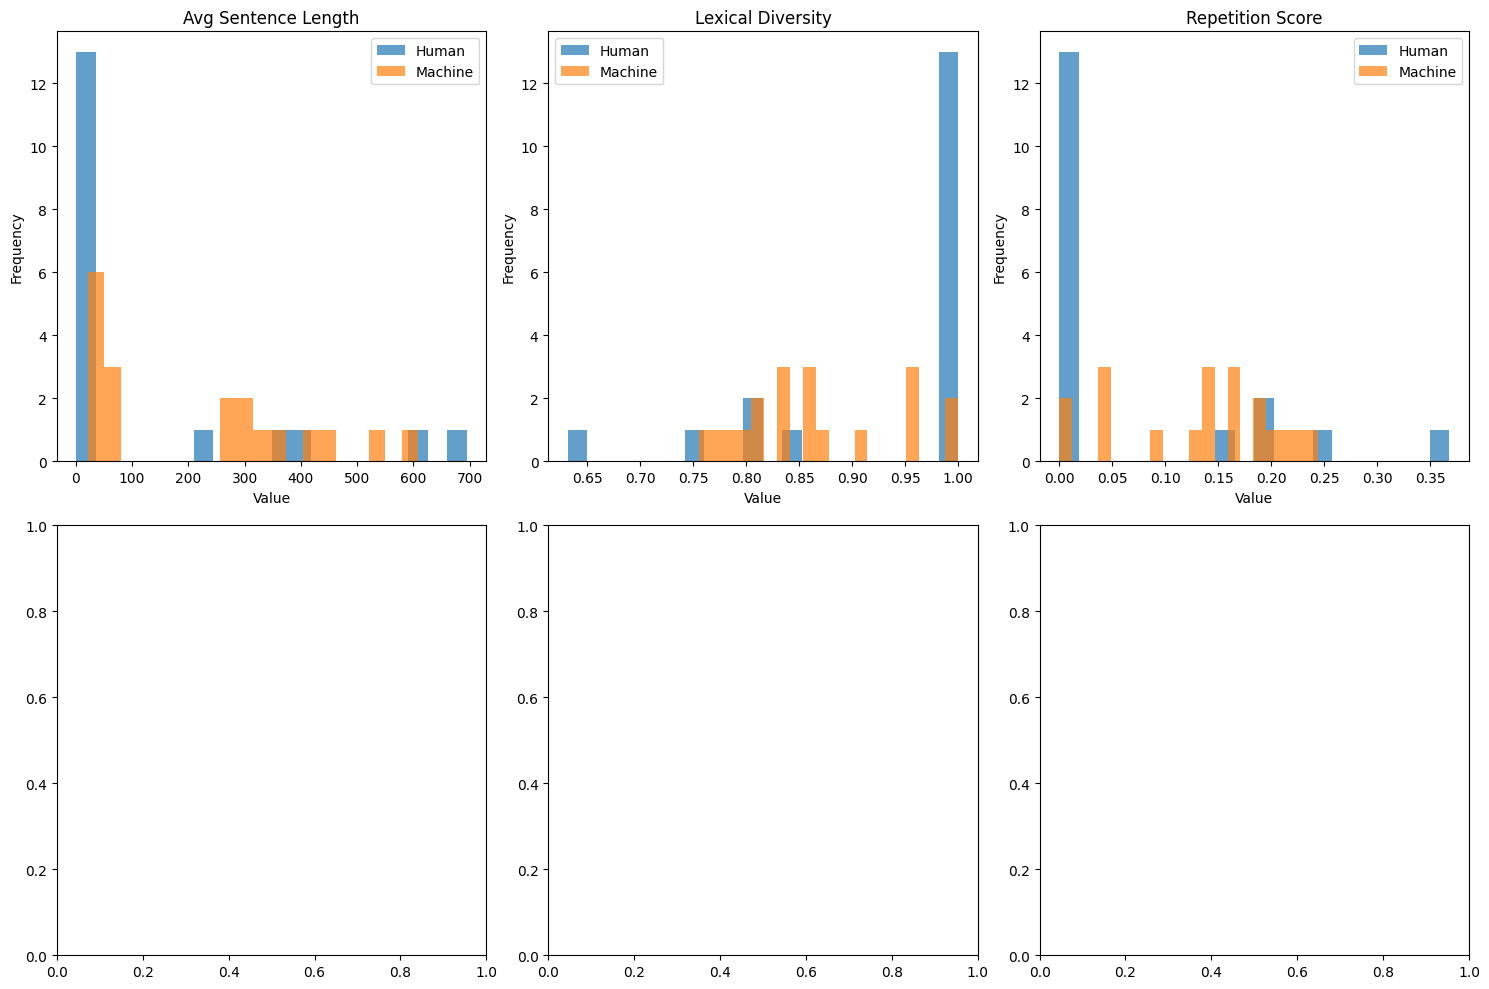


Sample prediction for 'Ezinye izisindo ze-XLMClassification azizange ziqaliswe endaweni yokuhlola yemodeli e-castorini futhi zisanda kuqaliswa.':
Predicted: Machine (confidence: 0.6246)


In [24]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from peft import LoraConfig, get_peft_model
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import shap
import lime
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
import re
from textstat import flesch_reading_ease, automated_readability_index
from collections import Counter

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class ZuluTextDataset(Dataset):
    """Custom Dataset class for Zulu text classification"""

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class ZuluTextClassifier:
    """AfriBERTa classifier for Zulu human vs machine text detection"""

    def __init__(self, model_name='castorini/afriberta_base', max_length=512):
        self.model_name = model_name
        self.max_length = max_length
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize tokenizer and model with AfriBERTa
        print(f"Loading AfriBERTa model: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2
        )
        self.model.to(self.device)

        print(f"Model initialized on {self.device}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")

    def prepare_data(self, df, text_column='cleaned_text', label_column='label', test_size=0.2):
        """Prepare and split the data"""
        # Filter for Zulu language if language column exists
        if 'language' in df.columns:
            df_zulu = df[df['language'].str.lower().isin(['zul'])].copy()
            print(f"Filtered {len(df_zulu)} Zulu samples from {len(df)} total samples")
        else:
            df_zulu = df.copy()
            print(f"Using all {len(df_zulu)} samples (no language filtering)")

        if len(df_zulu) == 0:
            raise ValueError("No Zulu samples found in the dataset")

        # Extract texts and labels
        texts = df_zulu[text_column].tolist()
        labels = df_zulu[label_column].tolist()

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            texts, labels,
            test_size=test_size,
            random_state=42,
            stratify=labels
        )

        print(f"Training samples: {len(X_train)}")
        print(f"Test samples: {len(X_test)}")
        print(f"Label distribution in training: {np.bincount(y_train)}")
        print(f"Label distribution in test: {np.bincount(y_test)}")

        return X_train, X_test, y_train, y_test

    def create_datasets(self, X_train, X_test, y_train, y_test):
        """Create PyTorch datasets"""
        train_dataset = ZuluTextDataset(X_train, y_train, self.tokenizer, self.max_length)
        test_dataset = ZuluTextDataset(X_test, y_test, self.tokenizer, self.max_length)

        return train_dataset, test_dataset

    def setup_lora(self, use_lora=True, lora_r=16, lora_alpha=32, lora_dropout=0.1):
        """Setup LoRA for parameter-efficient fine-tuning"""
        if use_lora:
            print("Setting up LoRA configuration...")
            lora_config = LoraConfig(
                r=lora_r,
                lora_alpha=lora_alpha,
                target_modules=["query", "key", "value"],
                lora_dropout=lora_dropout,
                bias="none",
                task_type="SEQ_CLS"
            )

            self.model = get_peft_model(self.model, lora_config)
            print(f"LoRA enabled. Trainable parameters: {self.model.num_parameters()}")
        else:
            print("Using full fine-tuning (no LoRA)")

    def train(self, train_dataset, eval_dataset, output_dir='./afriberta_zulu_classifier_results',
              use_lora=True, epochs=5, batch_size=8, learning_rate=5e-5):
        """Train the model"""

        # Setup LoRA if requested
        self.setup_lora(use_lora=use_lora)

        # Training arguments optimized for AfriBERTa
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            warmup_steps=100,
            weight_decay=0.01,
            learning_rate=learning_rate,
            logging_dir=f'{output_dir}/logs',
            logging_steps=10,
            eval_strategy="steps",
            eval_steps=50,
            save_strategy="steps",
            save_steps=50,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            save_total_limit=2,
            report_to="none",  # Disable wandb
            seed=42,
            dataloader_pin_memory=False,  # Better for some setups
            fp16=torch.cuda.is_available(),  # Use mixed precision if available
        )

        # Initialize trainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )

        # Train the model
        print("Starting training with AfriBERTa...")
        trainer.train()

        # Save the model
        trainer.save_model()
        self.tokenizer.save_pretrained(output_dir)

        return trainer

    def evaluate(self, test_dataset, trainer=None):
        """Evaluate the model"""
        if trainer is None:
            # Create a new trainer for evaluation
            trainer = Trainer(model=self.model)

        # Get predictions
        predictions = trainer.predict(test_dataset)
        y_pred = np.argmax(predictions.predictions, axis=1)
        y_true = predictions.label_ids

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

        # Per-class metrics
        precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
            y_true, y_pred, average=None
        )

        results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'f1_per_class': f1_per_class,
            'support': support,
            'y_true': y_true,
            'y_pred': y_pred
        }

        return results

    def print_evaluation_results(self, results):
        """Print detailed evaluation results"""
        print("\n" + "="*50)
        print("AFRIBERTA ZULU CLASSIFIER - EVALUATION RESULTS")
        print("="*50)

        print(f"Overall Accuracy: {results['accuracy']:.4f}")
        print(f"Weighted Precision: {results['precision']:.4f}")
        print(f"Weighted Recall: {results['recall']:.4f}")
        print(f"Weighted F1-Score: {results['f1']:.4f}")

        print("\nPer-Class Results:")
        class_names = ['Human', 'Machine']
        for i in range(len(class_names)):
            print(f"{class_names[i]}:")
            print(f"  Precision: {results['precision_per_class'][i]:.4f}")
            print(f"  Recall: {results['recall_per_class'][i]:.4f}")
            print(f"  F1-Score: {results['f1_per_class'][i]:.4f}")
            print(f"  Support: {results['support'][i]}")

        print("\nClassification Report:")
        print(classification_report(results['y_true'], results['y_pred'],
                                  target_names=class_names))

    def predict_single_text(self, text):
        """Predict a single text sample"""
        self.model.eval()

        # Tokenize the input
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Move to device
        encoding = {k: v.to(self.device) for k, v in encoding.items()}

        # Get prediction
        with torch.no_grad():
            outputs = self.model(**encoding)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class = torch.argmax(predictions, dim=-1).item()
            confidence = predictions.max().item()

        class_names = ['Human', 'Machine']
        return {
            'predicted_class': class_names[predicted_class],
            'confidence': confidence,
            'probabilities': {
                'Human': predictions[0][0].item(),
                'Machine': predictions[0][1].item()
            }
        }



class TextExplainabilityAnalyzer:
    """
    Explainability analysis for machine vs human text classification
    """

    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.class_names = ['Human', 'Machine']

        # Initialize LIME explainer
        self.lime_explainer = LimeTextExplainer(
            class_names=self.class_names
        )

    def predict_proba_for_lime(self, texts):
        """
        Prediction function compatible with LIME
        """
        predictions = []
        self.model.eval()

        for text in texts:
            # Tokenize
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=512,
                return_tensors='pt'
            )

            # Move to device
            encoding = {k: v.to(self.device) for k, v in encoding.items()}

            # Get prediction
            with torch.no_grad():
                outputs = self.model(**encoding)
                probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
                predictions.append(probs.cpu().numpy()[0])

        return np.array(predictions)

    def explain_with_lime(self, text, num_features=10):
        """
        Generate LIME explanation for a single text
        """
        explanation = self.lime_explainer.explain_instance(
            text,
            self.predict_proba_for_lime,
            num_features=num_features,
            num_samples=500  # Reduced from 1000 to 500 for faster processing
        )

        return explanation

    def explain_with_shap(self, texts, background_texts=None):
        """
        Generate SHAP explanations for texts
        """
        # Create a wrapper for SHAP
        def model_wrapper(texts):
            return self.predict_proba_for_lime(texts)

        # Initialize SHAP explainer
        if background_texts is None:
            # Use a smaller subset of training data as background
            background_texts = texts[:20]  # Reduced from 50 to 20

        explainer = shap.Explainer(model_wrapper, background_texts)
        shap_values = explainer(texts)

        return shap_values

    def analyze_feature_importance(self, test_texts, test_labels, sample_ratio=0.3):
        """
        Analyze what features the model focuses on for classification
        Args:
            test_texts: List of test texts
            test_labels: List of test labels
            sample_ratio: Ratio of samples to analyze (default 0.3 for 30%)
        """
        results = {
            'human_features': [],
            'machine_features': [],
            'common_patterns': {}
        }

        # Calculate number of samples to analyze
        total_samples = len(test_texts)
        num_samples = int(total_samples * sample_ratio)

        print(f"Analyzing {num_samples} samples ({sample_ratio*100:.0f}%) out of {total_samples} total samples")

        # Sample texts for analysis with stratification to maintain class balance
        from sklearn.model_selection import train_test_split

        # Create stratified sample
        sample_indices, _ = train_test_split(
            range(len(test_texts)),
            test_size=1-sample_ratio,
            stratify=test_labels,
            random_state=42
        )

        print(f"Selected {len(sample_indices)} samples for analysis")

        for i, idx in enumerate(tqdm(sample_indices, desc="Generating LIME explanations")):
            text = test_texts[idx]
            true_label = test_labels[idx]

            # Check if the text is empty or whitespace-only
            if not text or text.isspace():
                print(f"Skipping analysis for empty or whitespace-only text at index {idx}")
                continue

            # Add a try-except block in case LIME encounters issues with the text
            try:
                explanation = self.explain_with_lime(text)

                # Extract important features
                features = explanation.as_list()

                if true_label == 0:  # Human
                    results['human_features'].extend([f[0] for f in features if f[1] > 0])
                else:  # Machine
                    results['machine_features'].extend([f[0] for f in features if f[1] > 0])

            except Exception as e:
                print(f"Error generating LIME explanation for text at index {idx}: {e}")
                continue

        # Find common patterns
        from collections import Counter
        results['human_patterns'] = Counter(results['human_features']).most_common(20)
        results['machine_patterns'] = Counter(results['machine_features']).most_common(20)

        return results

    def visualize_explanations(self, text, explanation_type='lime'):
        """
        Visualize model explanations
        """
        if explanation_type == 'lime':
            explanation = self.explain_with_lime(text)

            # Show in notebook (if available) or save as HTML
            explanation.show_in_notebook(text=True)

            # Also create a matplotlib visualization
            fig = explanation.as_pyplot_figure()
            plt.tight_layout()
            return fig

    def linguistic_feature_analysis(self, texts, labels, sample_ratio=0.3):
        """
        Analyze linguistic features that distinguish human vs machine text
        Args:
            texts: List of texts
            labels: List of labels
            sample_ratio: Ratio of samples to analyze (default 0.3 for 30%)
        """
        # Sample texts for analysis
        total_samples = len(texts)
        num_samples = int(total_samples * sample_ratio)

        # Create stratified sample
        from sklearn.model_selection import train_test_split
        sample_indices, _ = train_test_split(
            range(len(texts)),
            test_size=1-sample_ratio,
            stratify=labels,
            random_state=42
        )

        sampled_texts = [texts[i] for i in sample_indices]
        sampled_labels = [labels[i] for i in sample_indices]

        print(f"Running linguistic analysis on {len(sampled_texts)} samples ({sample_ratio*100:.0f}%)")

        features = {
            'avg_sentence_length': [],
            'lexical_diversity': [],
            'repetition_score': []
        }

        for text in tqdm(sampled_texts, desc="Computing linguistic features"):
            # Average sentence length
            sentences = re.split(r'[.!?]+', text)
            avg_sent_len = np.mean([len(s.split()) for s in sentences if s.strip()])
            features['avg_sentence_length'].append(avg_sent_len)

            # Lexical diversity (unique words / total words)
            words = text.lower().split()
            lexical_div = len(set(words)) / len(words) if words else 0
            features['lexical_diversity'].append(lexical_div)

            # Repetition score (simple measure)
            word_counts = Counter(words)
            repetition = sum(count - 1 for count in word_counts.values()) / len(words) if words else 0
            features['repetition_score'].append(repetition)

        # Analyze differences between human and machine text
        human_features = {k: [v[i] for i, label in enumerate(sampled_labels) if label == 0]
                         for k, v in features.items()}
        machine_features = {k: [v[i] for i, label in enumerate(sampled_labels) if label == 1]
                           for k, v in features.items()}

        return human_features, machine_features, features

    def plot_feature_distributions(self, human_features, machine_features):
        """
        Plot distributions of linguistic features
        """
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        feature_names = list(human_features.keys())

        for i, feature in enumerate(feature_names):
            ax = axes[i]

            # Plot histograms
            ax.hist(human_features[feature], alpha=0.7, label='Human', bins=20)
            ax.hist(machine_features[feature], alpha=0.7, label='Machine', bins=20)

            ax.set_title(feature.replace('_', ' ').title())
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')
            ax.legend()

        plt.tight_layout()
        return fig

    def error_analysis(self, test_texts, test_labels, predictions, sample_ratio=0.3):
        """
        Analyze model errors and identify patterns
        Args:
            test_texts: List of test texts
            test_labels: List of test labels
            predictions: List of predictions
            sample_ratio: Ratio of samples to analyze for detailed error analysis
        """
        # Find all misclassified examples
        all_errors = []
        for i, (true_label, pred_label) in enumerate(zip(test_labels, predictions)):
            if true_label != pred_label:
                all_errors.append({
                    'text': test_texts[i],
                    'true_label': self.class_names[true_label],
                    'predicted_label': self.class_names[pred_label],
                    'index': i
                })

        # Sample errors for detailed analysis
        num_errors_to_analyze = max(1, int(len(all_errors) * sample_ratio))
        errors_to_analyze = np.random.choice(all_errors,
                                           min(num_errors_to_analyze, len(all_errors)),
                                           replace=False) if all_errors else []

        print(f"Found {len(all_errors)} total errors, analyzing {len(errors_to_analyze)} in detail")

        # Analyze error patterns
        error_analysis = {
            'total_errors': len(all_errors),
            'false_positives': len([e for e in all_errors if e['true_label'] == 'Human']),
            'false_negatives': len([e for e in all_errors if e['true_label'] == 'Machine']),
            'examples': all_errors[:10]  # Show first 10 errors
        }

        # Get explanations for sampled error cases
        error_explanations = []
        for error in tqdm(errors_to_analyze[:5], desc="Generating error explanations"):  # Analyze top 5 sampled errors
            try:
                explanation = self.explain_with_lime(error['text'])
                error_explanations.append({
                    'error': error,
                    'explanation': explanation.as_list()
                })
            except Exception as e:
                print(f"Error generating explanation: {e}")
                continue

        error_analysis['explanations'] = error_explanations

        return error_analysis

    def generate_explanation_report(self, test_texts, test_labels, predictions, sample_ratio=0.3):
        """
        Generate comprehensive explanation report
        Args:
            test_texts: List of test texts
            test_labels: List of test labels
            predictions: List of predictions
            sample_ratio: Ratio of samples to use for analysis (default 0.3 for 30%)
        """
        print("="*60)
        print("MODEL EXPLAINABILITY ANALYSIS REPORT")
        print(f"Analyzing {sample_ratio*100:.0f}% of data for efficiency")
        print("="*60)

        # Feature importance analysis
        print("\n1. FEATURE IMPORTANCE ANALYSIS")
        print("-" * 40)
        feature_analysis = self.analyze_feature_importance(test_texts, test_labels, sample_ratio)

        print("Top features indicating HUMAN text:")
        for feature, count in feature_analysis['human_patterns'][:10]:
            print(f"  - '{feature}': {count} occurrences")

        print("\nTop features indicating MACHINE text:")
        for feature, count in feature_analysis['machine_patterns'][:10]:
            print(f"  - '{feature}': {count} occurrences")

        # Linguistic analysis
        print("\n2. LINGUISTIC FEATURE ANALYSIS")
        print("-" * 40)
        human_features, machine_features, all_features = self.linguistic_feature_analysis(
            test_texts, test_labels, sample_ratio
        )

        for feature_name in human_features.keys():
            human_mean = np.mean(human_features[feature_name])
            machine_mean = np.mean(machine_features[feature_name])
            print(f"{feature_name.replace('_', ' ').title()}:")
            print(f"  Human avg: {human_mean:.3f}, Machine avg: {machine_mean:.3f}")

        # Error analysis
        print("\n3. ERROR ANALYSIS")
        print("-" * 40)
        error_analysis = self.error_analysis(test_texts, test_labels, predictions, sample_ratio)

        print(f"Total classification errors: {error_analysis['total_errors']}")
        print(f"False positives (Human → Machine): {error_analysis['false_positives']}")
        print(f"False negatives (Machine → Human): {error_analysis['false_negatives']}")

        print("\nExample misclassifications:")
        for i, example in enumerate(error_analysis['examples'][:3]):
            print(f"  {i+1}. True: {example['true_label']}, Predicted: {example['predicted_label']}")
            print(f"     Text: {example['text'][:100]}...")

        return {
            'feature_analysis': feature_analysis,
            'linguistic_analysis': (human_features, machine_features),
            'error_analysis': error_analysis
        }


# Updated usage function with sampling control
def add_explainability_to_classifier(classifier, test_texts, test_labels, predictions, sample_ratio=0.3):
    """
    Add explainability analysis to existing classifier
    Args:
        classifier: Trained classifier instance
        test_texts: List of test texts
        test_labels: List of test labels
        predictions: List of predictions
        sample_ratio: Ratio of samples to analyze (default 0.3 for 30%)
    """
    explainer = TextExplainabilityAnalyzer(
        classifier.model,
        classifier.tokenizer,
        classifier.device
    )

    # Generate comprehensive report with sampling
    report = explainer.generate_explanation_report(
        test_texts, test_labels, predictions, sample_ratio
    )

    # Create visualizations
    human_features, machine_features = report['linguistic_analysis']
    fig = explainer.plot_feature_distributions(human_features, machine_features)
    plt.show()

    return explainer, report


# Updated main function
def main():
    """Main function to run the Zulu text classification with AfriBERTa"""

    # Assuming balanced_df is available in your environment
    df = balanced_df

    # Initialize classifier with AfriBERTa
    classifier = ZuluTextClassifier(model_name='castorini/afriberta_base')

    # Prepare data
    X_train, X_test, y_train, y_test = classifier.prepare_data(df)

    # Create datasets
    train_dataset, test_dataset = classifier.create_datasets(X_train, X_test, y_train, y_test)

    # Train model with LoRA (recommended for efficiency)
    trainer = classifier.train(
        train_dataset,
        test_dataset,
        use_lora=True,
        epochs=5,
        batch_size=8,
        learning_rate=5e-5
    )

    # Evaluate
    results = classifier.evaluate(test_dataset, trainer)
    classifier.print_evaluation_results(results)

    # Run explainability analysis on 30% of data
    explainer, report = add_explainability_to_classifier(
        classifier, X_test, y_test, results['y_pred'], sample_ratio=0.3
    )

    # Test single prediction
    sample_text = "Ezinye izisindo ze-XLMClassification azizange ziqaliswe endaweni yokuhlola yemodeli e-castorini futhi zisanda kuqaliswa."
    prediction = classifier.predict_single_text(sample_text)
    print(f"\nSample prediction for '{sample_text}':")
    print(f"Predicted: {prediction['predicted_class']} (confidence: {prediction['confidence']:.4f})")


if __name__ == "__main__":
    main()